YBIGTA 2021-2 교육세션

# RNN 과제 : 뉴스 토픽 7중분류하기

**강의자 : 한지영**

<br>

주요 과제는 토큰화, 정수인코딩, 패딩, 모델링(Vanila RNN or LSTM, 모델링 딴걸로 하시려면 하셔도 됩니다!)입니다!

주석처리해 놓은 곳(Q1~Q7)을 채워서 완성해주시면 됩니다.

오늘 실습한 코드에 거의 답이 있고, 모델링 부분은 오늘 실습을 응용하면 됩니다! 참고해서 작성해주세요~ 화이링!


In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

In [6]:
train = pd.read_csv("data/train_data.csv", index_col=0)
test = pd.read_csv("data/test_data.csv", index_col=0)

In [7]:
train

,title,topic_idx
index,,
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...
45649,KB금융 미국 IB 스티펠과 제휴…선진국 시장 공략,1
45650,1보 서울시교육청 신종코로나 확산에 개학 연기·휴업 검토,2
45651,게시판 키움증권 2020 키움 영웅전 실전투자대회,1


### eda
EDA는 확인만 하시고 넘어가시면 됩니다~

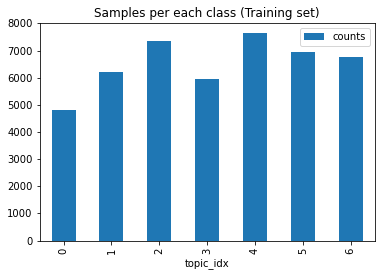

In [9]:
# 작가별 분포도 확인 
train.groupby(train.topic_idx).size().reset_index(name="counts").plot.bar(x='topic_idx',title="Samples per each class (Training set)")
plt.show()

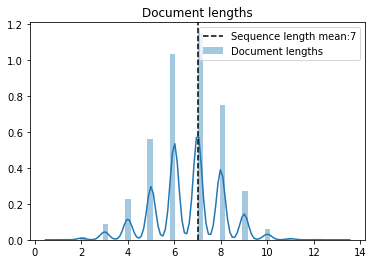

 가장 긴 문장은 13 개의 단어를, 가장 짧은 문장은 1 개의 단어를 가지고 있습니다.


In [10]:
# 문장 길이 분포도 확인
train['doc_len'] = train.title.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

### 텍스트 기본 전처리
코드 실행만 해주시고 넘어가시면 됩니다~

In [11]:
train.drop_duplicates(subset=['title'], inplace=True) # 중복값 있다면 제거

In [12]:
train = train.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [13]:
train['title'] = train['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train[:5]

,title,topic_idx,doc_len
index,,,
0,인천핀란드 항공기 결항휴가철 여행객 분통,4,5
1,실리콘밸리 넘어서겠다구글 조원 들여 전역 거점화,4,6
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4,8
3,클린턴 측근기업 특수관계 조명공과 사 맞물려종합,4,7
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4,7


In [14]:
# 한글만 남긴 이후, 빈 값이 된 행을 제거해줍시다.
train['title'] = train['title'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train['title'].replace('', np.nan, inplace=True)
train = train.dropna(how = 'any')

In [15]:
# test data에 대해서도 같은 과정을 수행해줍니다.
test.drop_duplicates(subset = ['title'], inplace=True) # title 열에서 중복인 내용이 있다면 중복 제거
test['title'] = test['title'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test['title'] = test['title'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test['title'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))

전처리 후 테스트용 샘플의 개수 : 9131


### 본 과제 시작! Q1~Q7을 채워주세요!

In [16]:
!pip3 install konlpy
from konlpy.tag import Okt

  Using cached beautifulsoup4-4.6.0-py3-none-any.whl (86 kB)
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-4.9.3


In [17]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

In [63]:
# 트레인데이터를 토큰화해주세요!
X_train = []
for sentence in train['title']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화, morphs는 텍스트를 형태소 단위로 나눠줍니다. okt.nouns() 이런 것도 있어요!
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [64]:
X_test = []
for sentence in test['title']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [65]:
vocab_size = 32000 # vocabsize는 2000으로 하겠습니다!
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train) #단어 집합 생성, 각 단어에 고유한 정수 부여(정수인코딩)

In [66]:
len(tokenizer.word_index)

26945

In [67]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 26945
등장 빈도가 2번 이하인 희귀 단어의 수: 13494
단어 집합에서 희귀 단어의 비율: 50.07979216923363
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.326704644741901


In [68]:
# Q5. texts_to_sequence()를 통해 X_train과 X_test의 텍스트 시퀀스를 숫자 시퀀스로 바꿔줍시다!
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
################################################################################

y_train = np.array(train['topic_idx'])
y_train = to_categorical(y_train, 7)

리뷰의 최대 길이 : 17
리뷰의 평균 길이 : 8.774494556765163


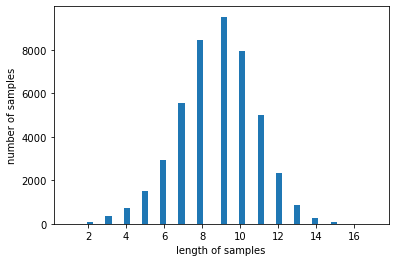

In [69]:
#리뷰 길이 분포 보기
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [70]:
max_len = 15

##### Q6. pad_sequences 함수 이용해서 패딩 진행해주세요! max_len도 지정해주세요! ######
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [74]:
embedding_dim = 3200 #vocab_size와 max_len 파라미터 세팅은 위에서 이미 진행했습니다! 이용해서 모델링 해주세요~

#################### Q7 ####################
# lstm/vanila RNN, 혹은 다른 모델도 상관 없습니다! import 할 거 하시고, 모델링을 해주세요!
# 힌트: 마지막 dense 층에서 출력 뉴런 수, 활성화 함수를 잘 설정하시는게 중요합니다!
# 힌트2: vocab_size와 max_len, embedding_dim 파라미터 이용해서 모델링 해주세요~

from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(layers.SpatialDropout1D(0.4))
model.add(
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
)
model.add(layers.Bidirectional(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(7, activation='sigmoid'))

In [77]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) #검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다.
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) #ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

In [79]:
#학습을 진행시켜봅시다! 셀을 실행시켜주세요! epoch, validation_split은 원하시는대로 바꾸셔도 되고, Early Stopping 응용하셔도 됩니다!
with tf.device("/gpu:0"):
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=1024, validation_split=0.2)

Epoch 1/30
36/36 [==============================] - ETA: 0s - loss: 0.4986 - acc: 0.8372
Epoch 00001: val_acc improved from -inf to 0.75326, saving model to best_model.h5
36/36 [==============================] - 164s 5s/step - loss: 0.4986 - acc: 0.8372 - val_loss: 0.7117 - val_acc: 0.7533
Epoch 2/30
36/36 [==============================] - ETA: 0s - loss: 0.2698 - acc: 0.9158
Epoch 00002: val_acc did not improve from 0.75326
36/36 [==============================] - 160s 4s/step - loss: 0.2698 - acc: 0.9158 - val_loss: 0.7666 - val_acc: 0.7421
Epoch 3/30
36/36 [==============================] - ETA: 0s - loss: 0.1691 - acc: 0.9472
Epoch 00003: val_acc did not improve from 0.75326
36/36 [==============================] - 161s 4s/step - loss: 0.1691 - acc: 0.9472 - val_loss: 0.8579 - val_acc: 0.7432
Epoch 4/30
36/36 [==============================] - ETA: 0s - loss: 0.1120 - acc: 0.9655
Epoch 00004: val_acc did not improve from 0.75326
36/36 [==============================] - 162s 4s/ste

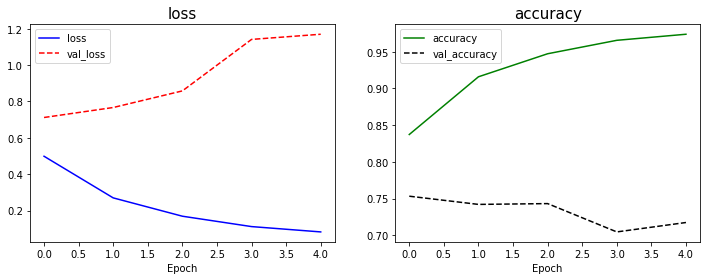

In [80]:
#에러 없이, 원하는 모델로 마지막 epoch까지 학습을 완료시켜주시고 이 셀을 실행시켜주세요! 에러 없이 해당셀까지 실행시켜주시면 성공입니다~

# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy', fontsize= 15)
plt.plot(history.history['acc'], 'g-', label='accuracy')
plt.plot(history.history['val_acc'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

------

**수고하셨습니다🥰🥰🥰**